In [1]:
from google.colab import drive
drive.mount('/foo',force_remount=True)

Mounted at /foo


In [2]:
import sys
sys.path.append('/foo/My Drive/')

In [22]:
import nltk
nltk.download('nps_chat')
from nltk.corpus import nps_chat
nps_chat.tagged_posts()

[nltk_data] Downloading package nps_chat to /root/nltk_data...
[nltk_data]   Package nps_chat is already up-to-date!


[[('now', 'RB'), ('im', 'PRP'), ('left', 'VBD'), ('with', 'IN'), ('this', 'DT'), ('gay', 'JJ'), ('name', 'NN')], [(':P', 'UH')], ...]

In [23]:
from sklearn.model_selection import train_test_split
from tensorflow import keras as k
import numpy as np
import re

In [24]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# %cd /foo/My\ Drive/Colab\ Notebooks/NLP/glove

glove_path = '/foo/My Drive/Colab Notebooks/NLP/glove/glove.6B.100d.txt'
embedding_index={}
with open(glove_path, 'r') as pretrained:
    for line in pretrained:
        word, coef = line.split(maxsplit=1)
        coef = np.fromstring(coef, "f", sep=" ")
        embedding_index[word] = coef

embedding_dim = len(embedding_index["the"])
embedding_dim

100

In [25]:
vocab = [w.lower() for w in nps_chat.words()]
vocab = list(set(vocab)) # create set of words
word_index=dict(zip(vocab,range(len(vocab)))) # map each word to it's indices

embedding_matrix = np.zeros((len(vocab)+2 , 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(5443, 100)

In [26]:
def filters(punc=True):
    def inner_filters(x):
        punctuation = r"\^\.|[\.|\`|:|,|\)|\(|\"|\']+"
        condition = [x[0].strip() , x[1].strip()]
        if punc:
            condition.append(not(re.match(punctuation, x[0].strip())))
            condition.append(not(re.match(punctuation, x[1].strip())))
        return  all(condition)

    return inner_filters
    
data = [list(filter(filters(True) , sentence)) for sentence in nps_chat.tagged_posts()]
data = list(filter(lambda vec:len(vec),data)) # remove empty lists

In [27]:
def word_to_int(data,mapper,index_shift=1,padding=True):
    # map each word to an integer, 1 for OOV (out of vocab)
    word2int = lambda vec: [mapper[word]+ index_shift if word in mapper.keys() else 1 for word in vec]
    mapped_data = list(map(word2int, data))
    if padding:
        mapped_data=k.preprocessing.sequence.pad_sequences(mapped_data, padding= 'post') # pad sentences with 0
    return mapped_data

In [28]:
train_data = [[tup[0].lower() for tup in sentence] for sentence in data] # extract training data from corpus
n= int(len(train_data)/10)
test_data = train_data[:n]
train_data = train_data[n:]

train_data = np.array(word_to_int(train_data,word_index,index_shift=2,padding=True))
test_data = word_to_int(test_data,word_index,index_shift=2,padding=False) # no padding for test data

print("train_data",train_data.shape)
print("test_data",len(test_data))

train_data (9430, 72)
test_data 1047


In [29]:
label = [[tup[1] for tup in sentence] for sentence in data] # extract training label from corpus

# Let's see what we have in tags:
tag_set = set(sum(label,[]))
print("number of tags in data:",len(tag_set))
print(" - ".join(tag_set))

# remove "^" character
label = [[word.replace("^","") for word in sentence] for sentence in label]

# replace all punctuation with one label
label = [[re.sub(r"[\.|\`|:|,|\)|\(|\"|\']+","Punctuation",word) for word in sentence] for sentence in label]

tag_set = list(set(sum(label,[])))
print("\nnumber of tags in data after preprocessing:",len(tag_set))
print(" - ".join(tag_set),"\n")

test_label = label[:n]
train_label = label[n:]

mapper = dict(zip(tag_set, range(len(tag_set))))

train_label = np.array(word_to_int(train_label,mapper,index_shift=1,padding=True))
test_label = word_to_int(test_label,mapper,index_shift=1,padding=False)

print("train_label",train_label.shape)
print("test_label",len(test_label))

number of tags in data: 64
^VBP - WRB - JJR - ^WP - NNS - ^DT - ^NN - ^VB - ^RB - RBR - MD - TO - ^PRP^VBP - ^VBG - ^MD - DT - ^PRP - GW - VBZ - IN - VBP - RP - NNPS - NN - CD - ^JJR - ^PRP$ - CC - ^VBZ - RBS - ^VBD - ^CC - ^POS - ^NNS - EX - ^IN - ^VBN - WP - SYM - ^NNP - X - ^WRB - VB - VBG - JJS - UH - ^TO - RB - WDT - ^JJS - NNP - ^JJ - PRP$ - VBN - FW - ^UH - VBD - ^RP - LS - PRP - POS - BES - JJ - PDT

number of tags in data after preprocessing: 39
WRB - JJR - NNS - RBR - MD - TO - DT - GW - VBZ - IN - VBP - RP - NNPS - NN - CD - CC - RBS - EX - WP - SYM - X - VB - PRPVBP - VBG - JJS - UH - RB - WDT - NNP - PRP$ - VBN - FW - VBD - LS - PRP - POS - BES - JJ - PDT 

train_label (9430, 72)
test_label 1047


In [30]:
train_sahpe = (train_data.shape[1], )
rnn_cell_dim = 64

In [31]:
input = k.layers.Input(shape=train_sahpe)
embedded = k.layers.Embedding(len(vocab)+2,embedding_dim,mask_zero=True,
                              embeddings_initializer=k.initializers.Constant(embedding_matrix),
                              trainable=False)(input)
rnn_layer = k.layers.GRU(rnn_cell_dim, return_sequences=True)
rnn_output = k.layers.Bidirectional(rnn_layer, merge_mode='concat')(embedded)
rnn_output = k.layers.Bidirectional(rnn_layer, merge_mode='concat')(rnn_output)
predictions = k.layers.Dense(len(tag_set)+1, activation='softmax')(rnn_output)

model = k.Model(inputs=input, outputs=predictions)

print(model.summary())

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 72)]              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 72, 100)           544300    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 72, 128)           63744     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 72, 128)           74496     
_________________________________________________________________
dense_2 (Dense)              (None, 72, 40)            5160      
Total params: 687,700
Trainable params: 143,400
Non-trainable params: 544,300
_________________________________________________________________
None


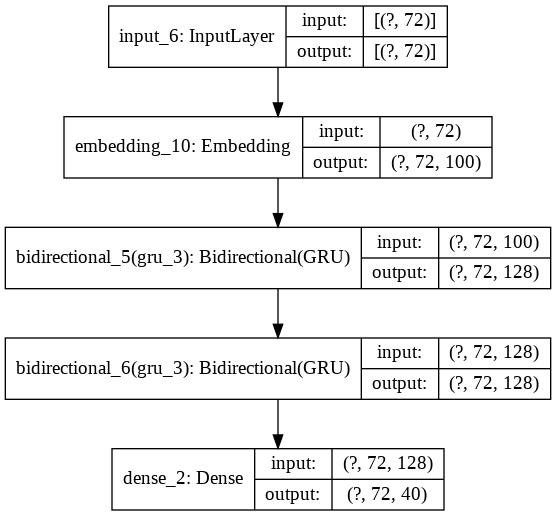

In [32]:
k.utils.plot_model(model, show_shapes=True)

In [33]:
batch = 100
num_epochs = 20
model.compile(optimizer=k.optimizers.Adam(),
                           loss=k.losses.SparseCategoricalCrossentropy(),
                           metrics=[k.metrics.SparseCategoricalAccuracy(name='accuracy')])

model.fit(x=train_data,y=train_label, batch_size=batch, epochs=num_epochs, validation_split=0.1)

Epoch 1/20
85/85 [==============================] - 30s 348ms/step - loss: 0.1401 - accuracy: 0.3155 - val_loss: 0.0950 - val_accuracy: 0.4239
Epoch 2/20
85/85 [==============================] - 25s 297ms/step - loss: 0.0947 - accuracy: 0.5056 - val_loss: 0.0757 - val_accuracy: 0.5223
Epoch 3/20
85/85 [==============================] - 25s 297ms/step - loss: 0.0803 - accuracy: 0.5699 - val_loss: 0.0662 - val_accuracy: 0.6122
Epoch 4/20
85/85 [==============================] - 25s 297ms/step - loss: 0.0721 - accuracy: 0.6234 - val_loss: 0.0605 - val_accuracy: 0.6375
Epoch 5/20
85/85 [==============================] - 25s 297ms/step - loss: 0.0662 - accuracy: 0.6517 - val_loss: 0.0573 - val_accuracy: 0.6594
Epoch 6/20
85/85 [==============================] - 25s 297ms/step - loss: 0.0617 - accuracy: 0.6729 - val_loss: 0.0553 - val_accuracy: 0.6705
Epoch 7/20
85/85 [==============================] - 25s 297ms/step - loss: 0.0579 - accuracy: 0.6924 - val_loss: 0.0535 - val_accuracy: 0.6777

In [ ]:
eval_data = k.preprocessing.sequence.pad_sequences(test_data,padding='post')
eval_label = k.preprocessing.sequence.pad_sequences(test_label,padding='post')
model.evaluate(x=eval_data,y=eval_label)

10/10 [==============================] - 1s 70ms/step - loss: 0.0621 - accuracy: 0.7278


[0.06211025267839432, 0.7277619242668152]

In [ ]:
pred=[]
for sentence in test_data:
    prediction = model.predict(np.array(sentence))
    prediction = np.argmax(prediction, axis=-1).tolist()
    prediction = prediction[:len(sentence)]
    pred.append(prediction)

In [ ]:
from sklearn import metrics

y_true, y_pred = sum(test_label,[]), sum(pred,[])

#print(metrics.confusion_matrix(y_true, y_pred)
print(metrics.classification_report(y_true,y_pred, labels=range(len(tag_set)+1), target_names=tag_set))


              precision    recall  f1-score   support

         VBP       0.00      0.00      0.00         0
          TO       0.84      0.39      0.53       148
         WDT       0.00      0.00      0.00        57
          NN       0.00      0.00      0.00         5
          DT       0.80      0.24      0.37       414
         BES       0.91      0.80      0.85       196
          RP       0.00      0.00      0.00         1
         PRP       0.64      0.67      0.65        21
          MD       0.90      0.59      0.71       384
          VB       1.00      0.68      0.81        34
          UH       0.86      0.61      0.71       375
         NNS       0.24      0.94      0.38       447
         PDT       0.56      0.18      0.27       111
         RBS       0.00      0.00      0.00         1
         JJR       1.00      1.00      1.00         1
         NNP       0.00      0.00      0.00         6
          WP       0.67      0.59      0.62       381
          FW       0.95    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1989: UserWarning: labels size, 40, does not match size of target_names, 39
  .format(len(labels), len(target_names))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
